# Analysis of Surface Fields

`mom6_tools.MOM6grid` returns an object with MOM6 grid data.

`mom6_tools.latlon_analysis` has a collection of tools used to perform spatial analysis  (e.g., time averages and spatial mean).

The goal of this notebook is the following:

1) server as an example of how to post-process CESM/MOM6 output;

2) create time averages of surface fields;

3) create time-series of globally-averaged surface fields;

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import os
import warnings

from dask.distributed import Client, LocalCluster
import intake
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.surface import get_MLD, get_BLD
import xarray as xr

warnings.filterwarnings("ignore")

Basemap module not found. Some regional plots may not function properly


In [3]:
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
Case = "b.e23_alpha16b.BLT1850.ne30_t232.054"
savefigs = False
mom6_tools_config = {}
lc_kwargs = {}

In [4]:
# Parameters
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
lc_kwargs = {"threads_per_worker": 1}
Case = "b.e23_alpha16b.BLT1850.ne30_t232.054"
savefigs = False
mom6_tools_config = {
    "start_date": "0091-01-01",
    "end_date": "0101-01-01",
    "Fnames": {"native": "mom6.h.native.????-??.nc", "static": "mom6.h.static.nc"},
    "oce_cat": "/glade/u/home/gmarques/libs/oce-catalogs/reference-datasets.yml",
}
subset_kwargs = {}
product = "/glade/u/home/dbailey/CUPiD/examples/coupled_model/computed_notebooks/quick-run/ocean_surface.ipynb"


In [5]:
OUTDIR = f'{CESM_output_dir}/{Case}/ocn/hist/'
print('Output directory is:', OUTDIR)

Output directory is: /glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing/b.e23_alpha16b.BLT1850.ne30_t232.054/ocn/hist/


In [6]:
# The following parameters must be set accordingly
######################################################

# create an empty class object
class args:
  pass

args.start_date = mom6_tools_config['start_date']
args.end_date = mom6_tools_config['end_date']
args.casename = Case
args.native = f"{Case}.{mom6_tools_config['Fnames']['native']}"
args.static = f"{Case}.{mom6_tools_config['Fnames']['static']}"
args.mld_obs = "mld-deboyer-tx2_3v2"
args.savefigs = savefigs

In [7]:
if not os.path.isdir('PNG/BLD'):
  print('Creating a directory to place figures (PNG/BLD)... \n')
  os.system('mkdir -p PNG/BLD')
if not os.path.isdir('PNG/MLD'):
  print('Creating a directory to place figures (PNG/MLD)... \n')
  os.system('mkdir -p PNG/MLD')
if not os.path.isdir('ncfiles'):
  print('Creating a directory to place netcdf files (ncfiles)... \n')
  os.system('mkdir ncfiles')    

In [8]:
# Spin up cluster
cluster = LocalCluster(**lc_kwargs)
client = Client(cluster)

client

<Client: 'tcp://127.0.0.1:34565' processes=12 threads=12, memory=120.00 GiB>

In [9]:
# load mom6 grid
grd = MOM6grid(OUTDIR+args.static)
grd_xr = MOM6grid(OUTDIR+args.static, xrformat=True)

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 



In [10]:
print('Reading native dataset...')
startTime = datetime.now()

def preprocess(ds):
  ''' Compute montly averages and return the dataset with variables'''
  variables = ['oml','mlotst','tos','SSH', 'SSU', 'SSV', 'speed', 'time_bnds']
  for v in variables:
    if v not in ds.variables:
      ds[v] = xr.zeros_like(ds.SSH)
  return ds[variables]

ds1 = xr.open_mfdataset(OUTDIR+args.native, parallel=False)
ds = preprocess(ds1)

print('Time elasped: ', datetime.now() - startTime)

Reading native dataset...


Time elasped:  0:04:16.644257


In [11]:
print('Selecting data between {} and {}...'.format(args.start_date, args.end_date))
ds_sel = ds.sel(time=slice(args.start_date, args.end_date))

Selecting data between 0091-01-01 and 0101-01-01...


In [12]:
catalog = intake.open_catalog(mom6_tools_config['oce_cat'])
mld_obs = catalog[args.mld_obs].to_dask()
# uncomment to list all datasets available
#list(catalog)

### Mixed layer depth

Computing monthly MLD climatology...


Time elasped:  0:00:26.134248

 Plotting...


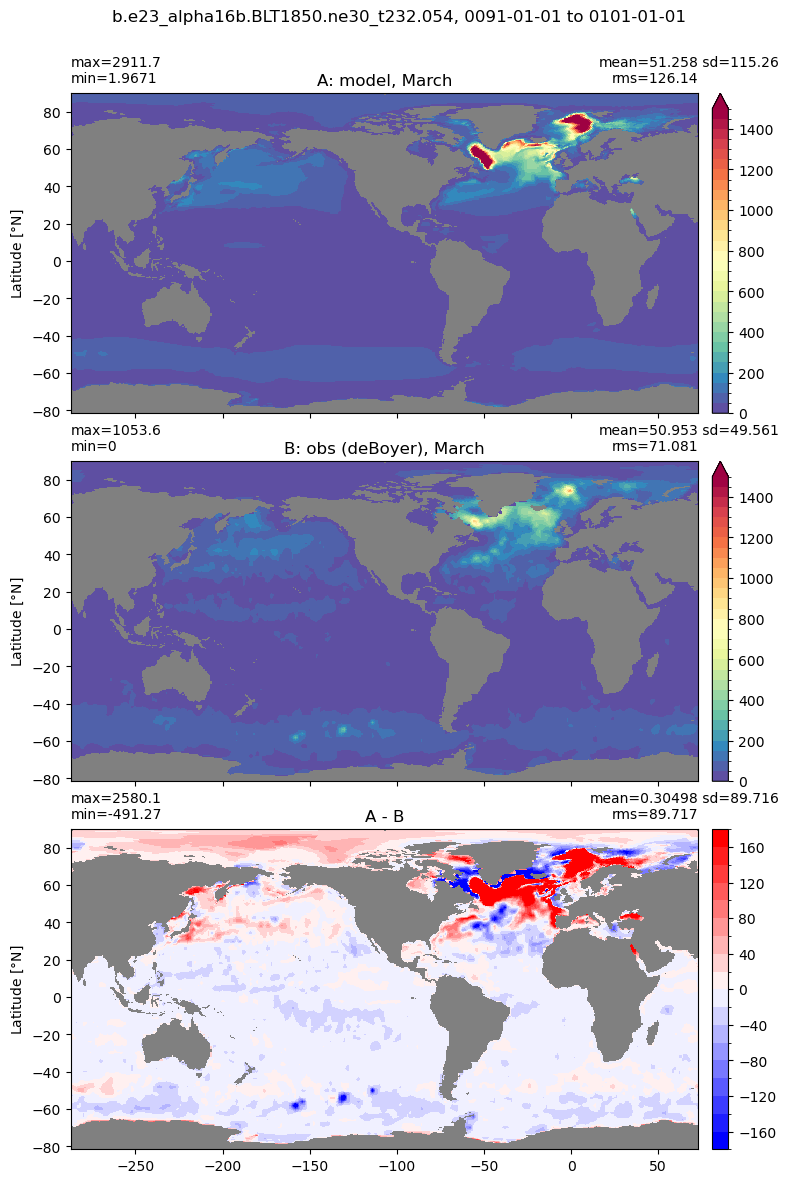

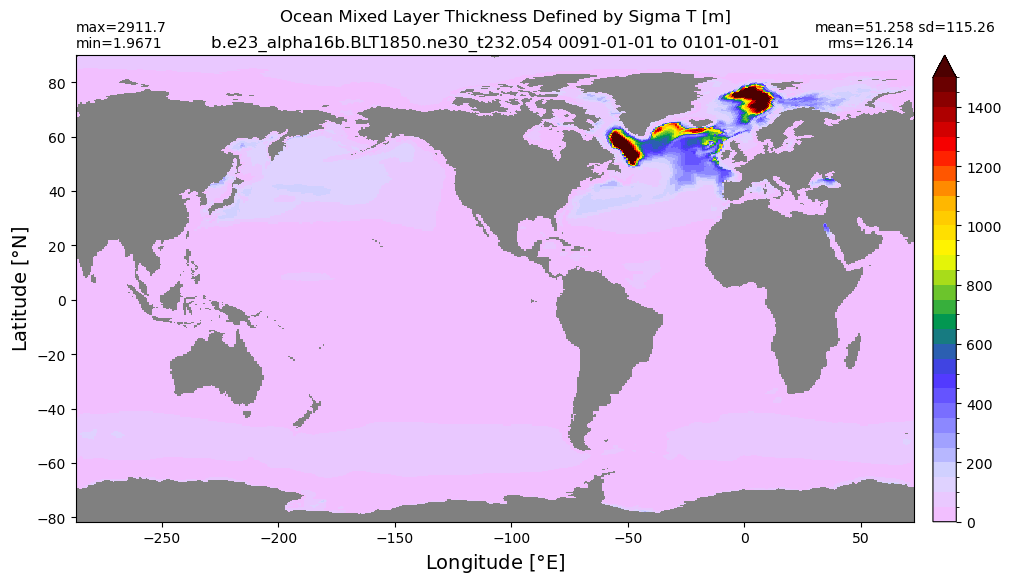

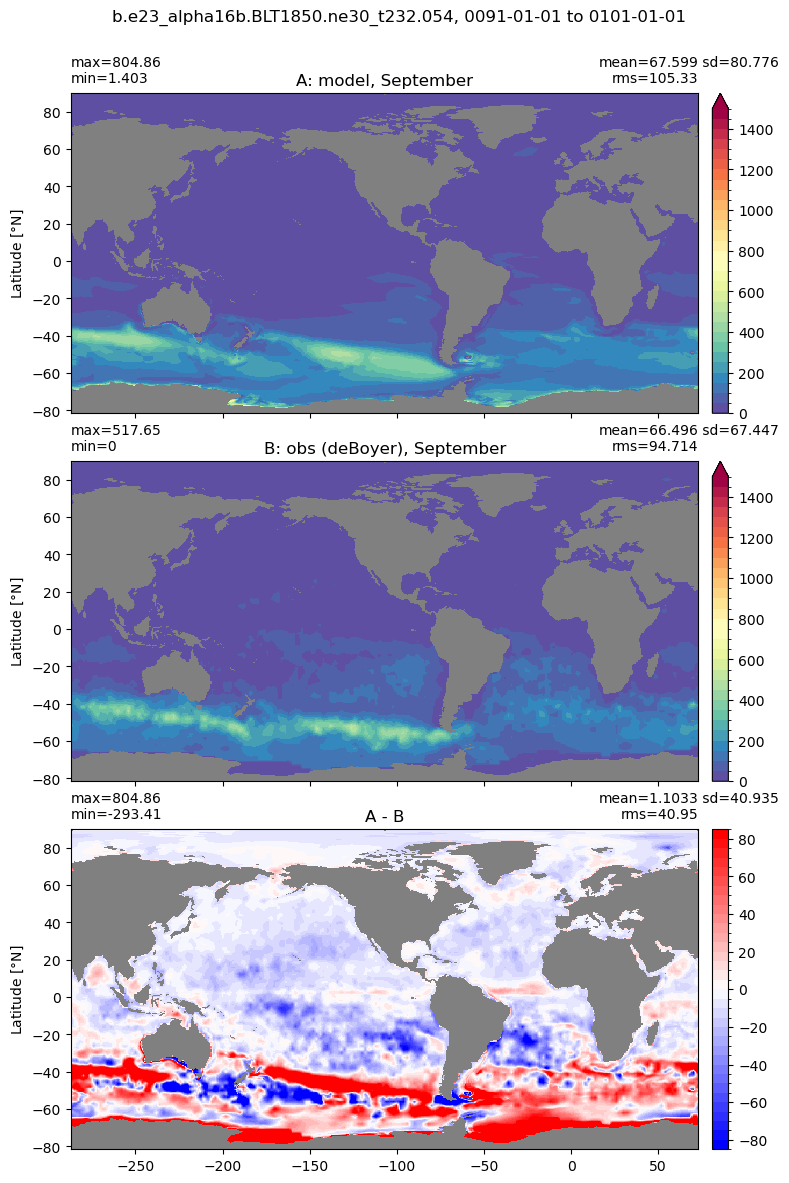

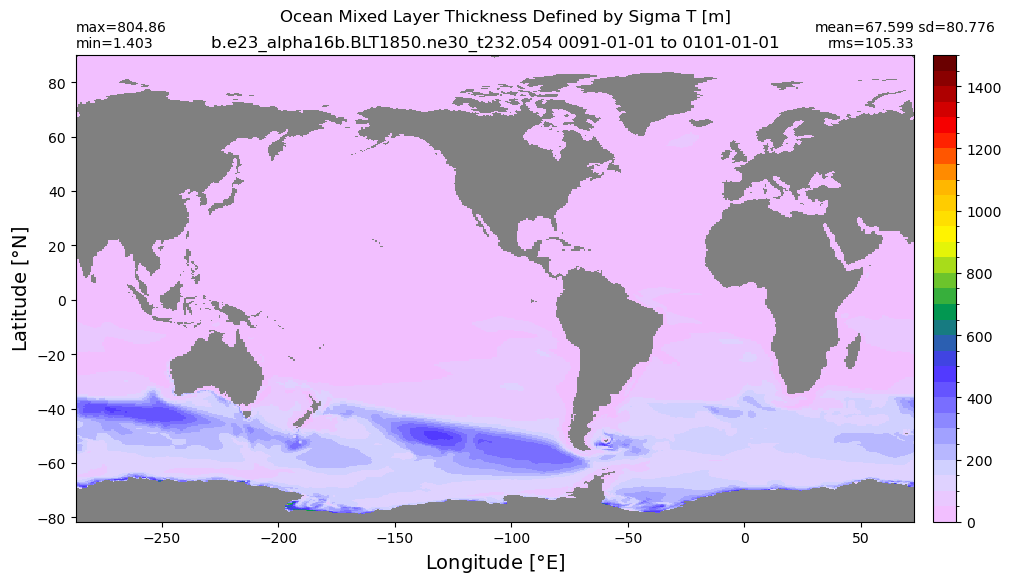

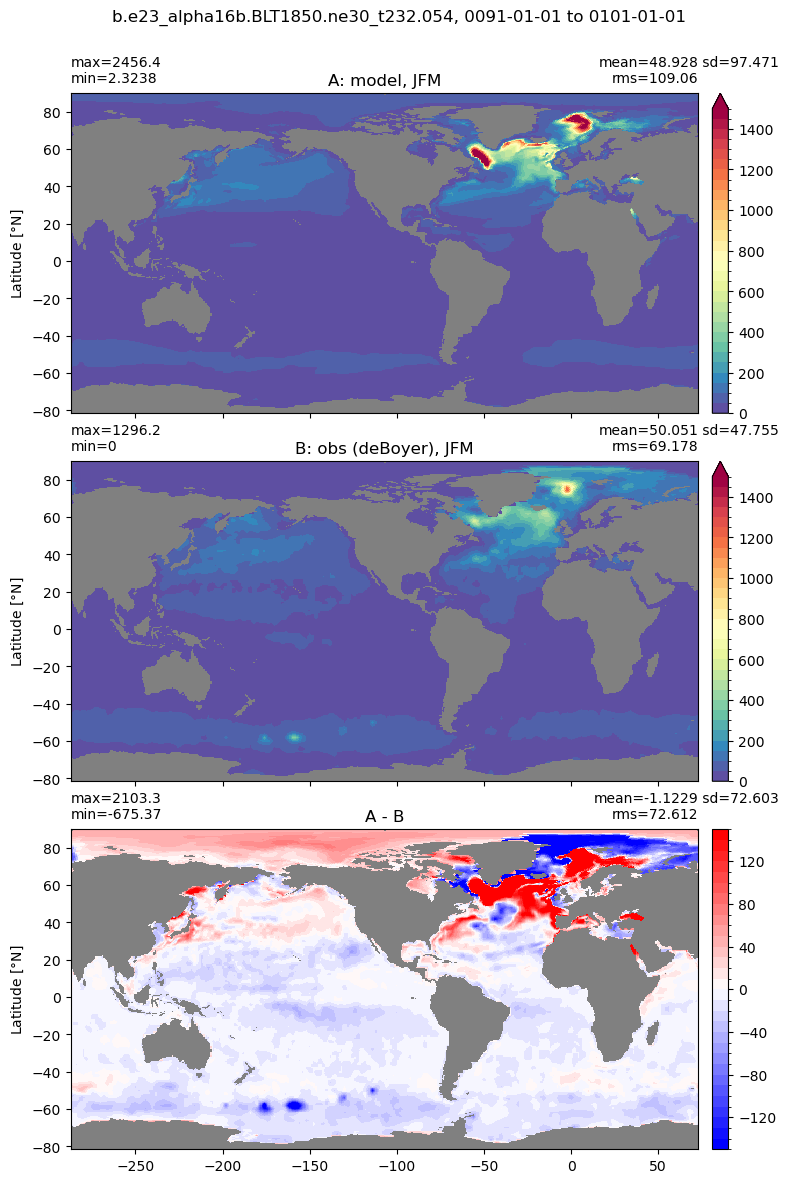

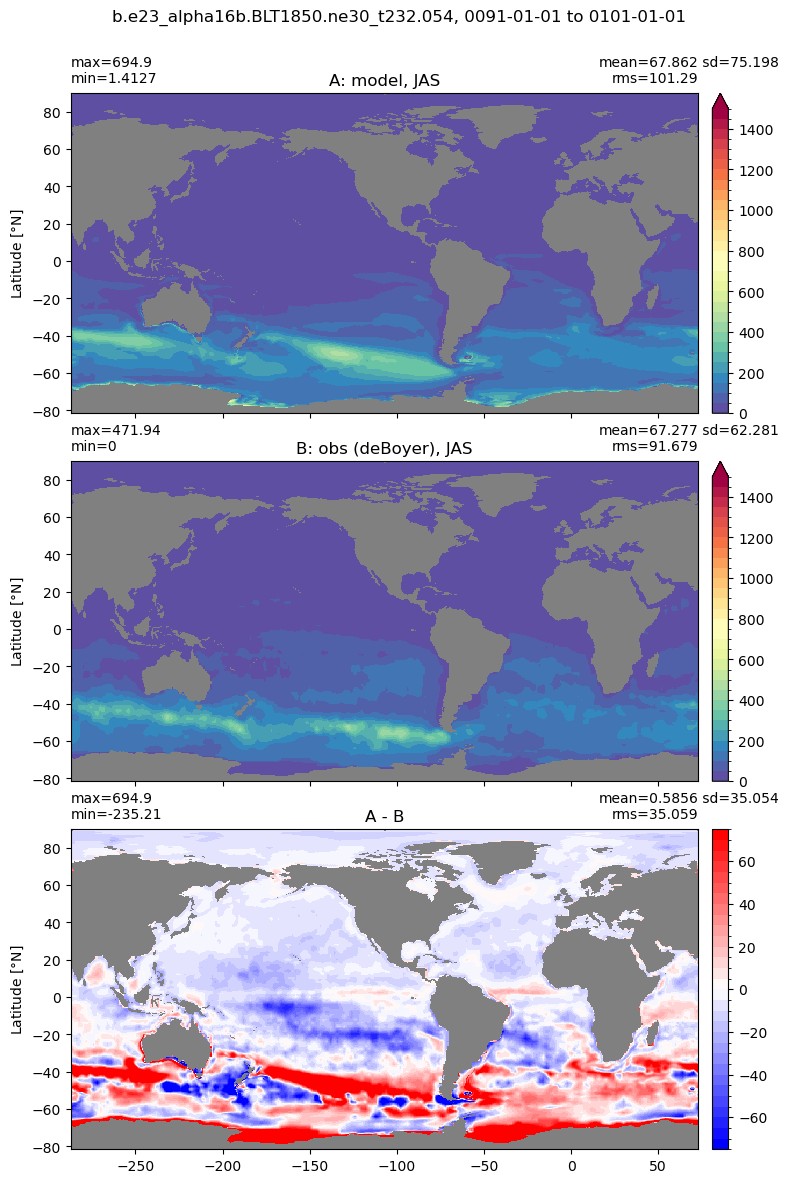

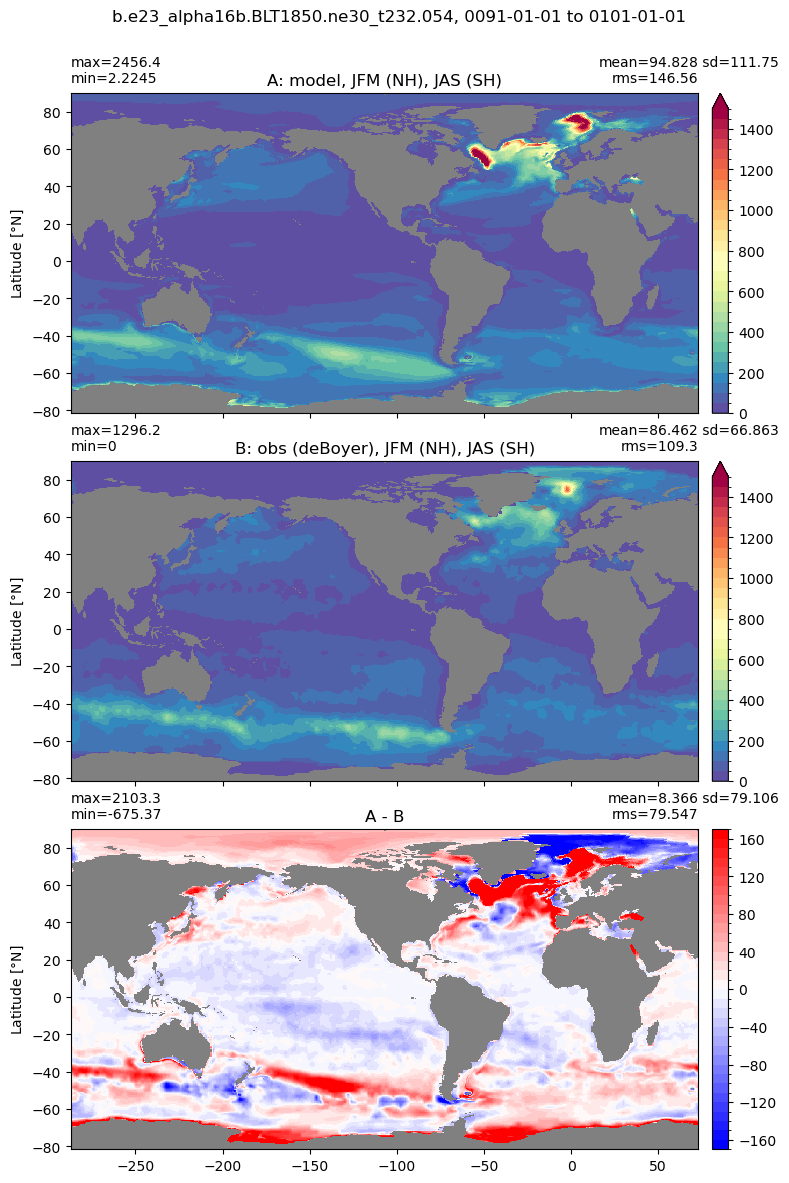

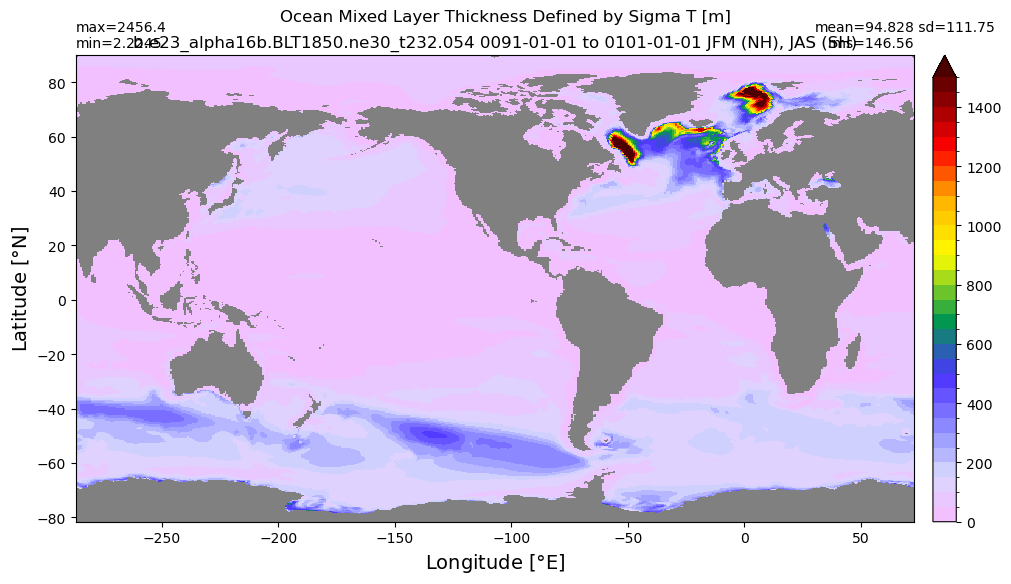

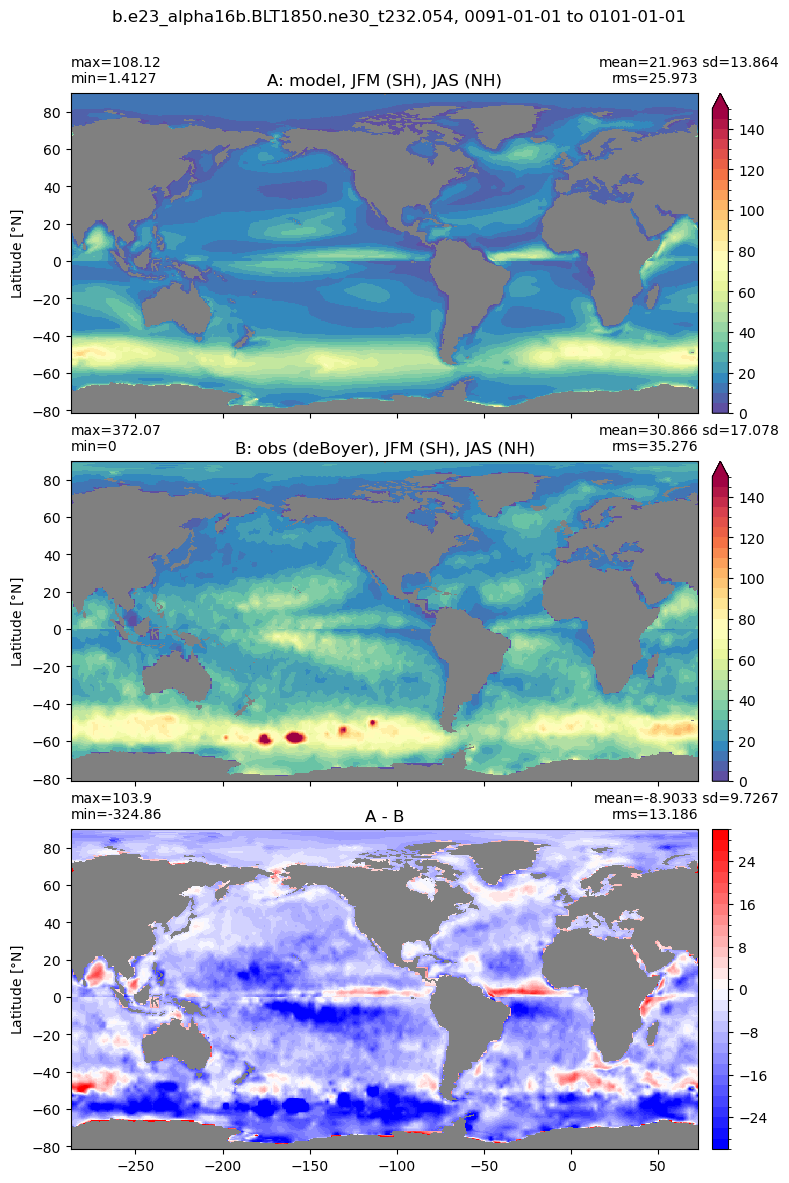

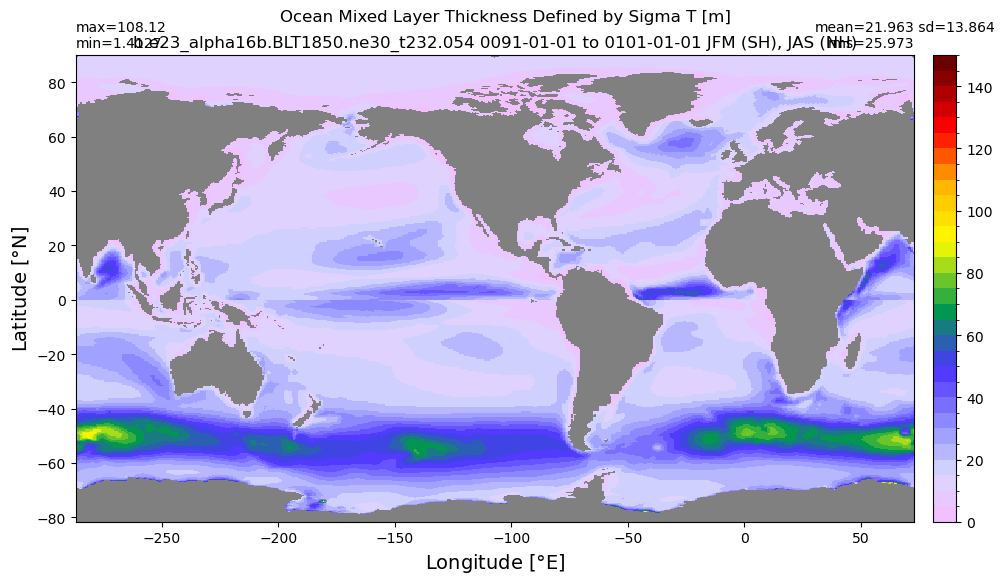

In [13]:
%matplotlib inline
# MLD
get_MLD(ds,'mlotst', mld_obs, grd, args)

### Boundary layer depth

Computing monthly BLD climatology...


Time elasped:  0:00:22.422654

 Plotting...


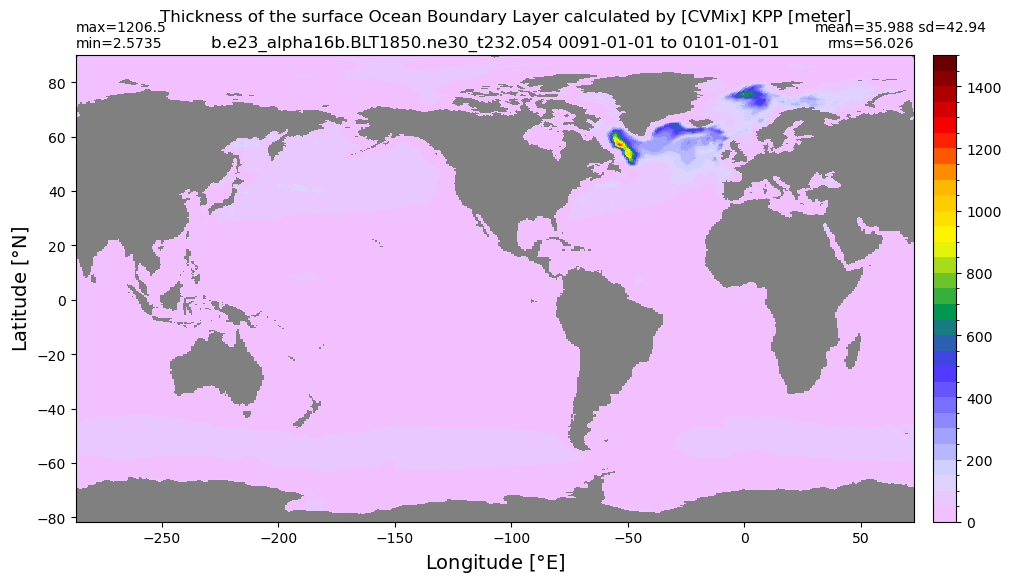

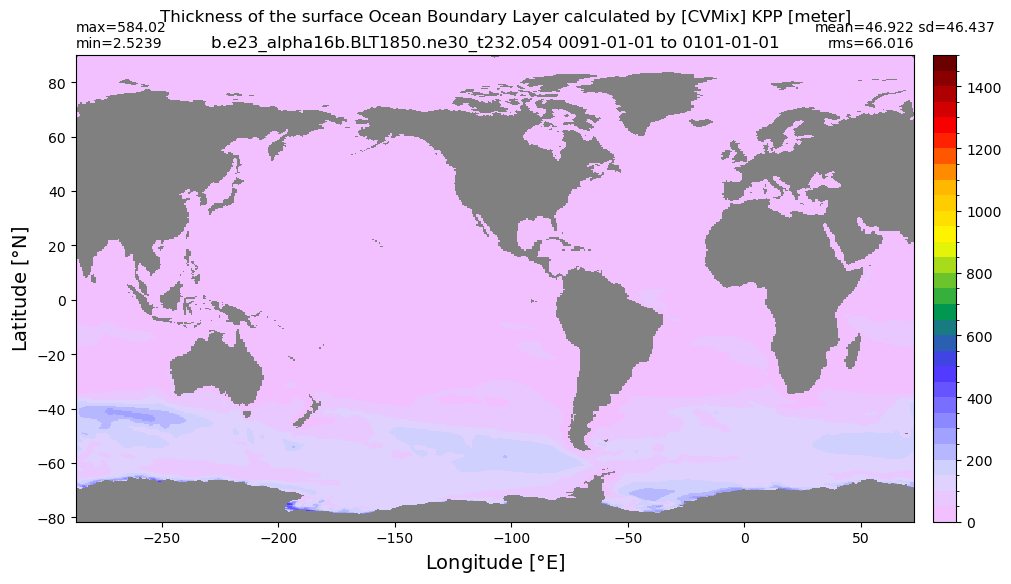

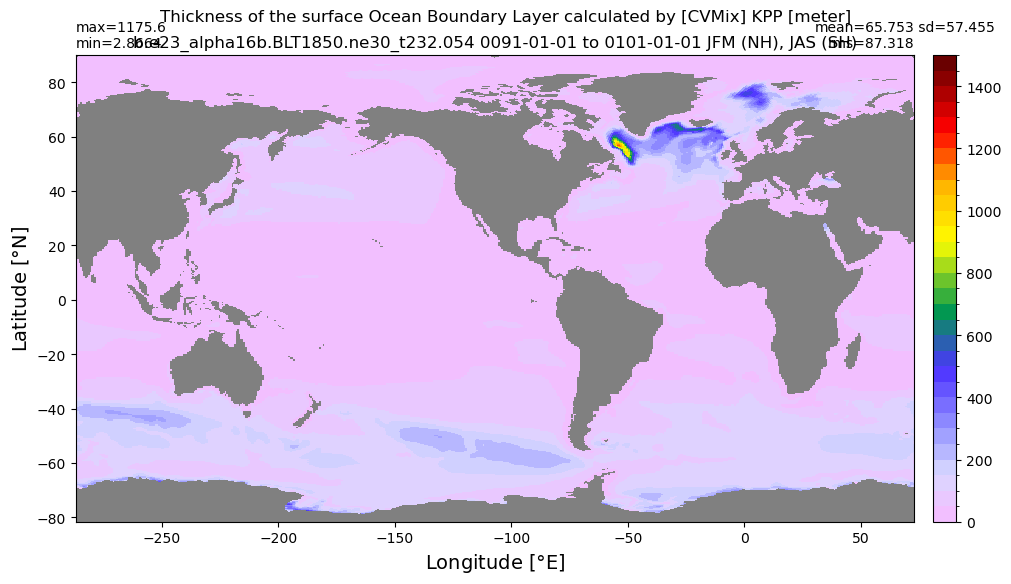

In [14]:
get_BLD(ds, 'oml', grd, args)

In [15]:
# SSH (not working)
#get_SSH(ds, 'SSH', grd, args)